# Chapter 2 - Univariate Returns

In [5]:
%load_ext autoreload
%autoreload 2

## Load S&P 500 Data

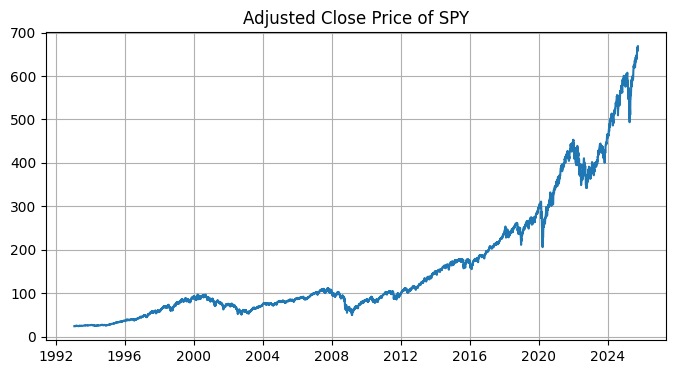

In [40]:
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

def load_data():
    spx = yf.Ticker("SPY")
    hist = spx.history(start="1950-01-01", interval="1d", auto_adjust=False)
    return hist
data = load_data()
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(data["Adj Close"])
ax.set_title("Adjusted Close Price of SPY")
ax.grid()

## 2.1 Returns

## Return Definitions

**Return** is defined as:

$$r\left(1\right) := \frac{P\left(1\right) + D\left(1\right) - P\left(0\right)}{P\left(0\right)}$$

Where $P\left(t\right)$ is the price at time $t$ and $D\left(t\right)$ is the dividend (if any) at time $t$

**Excess Return** is defined as $r - r_f$ where $r_f$ is the risk free rate e.g. Secured Overnight Financing Rate (SOFR)

**Log Return** is defined as 

$$\tilde{r}_1 := \log\left(1+r_1\right)$$

## Return vs. Log Return

Three key points to verify:

- Returns compounds to calculate cumulative returns, the distribution diverges from normal distribution when the single period return is close to normal distribution.

- On the other hand, log returns are additive over time, the distribution doesn't diverge much from normal distribution.

- By Taylor expansion, we get $\tilde{r} = r + o\left({\left|r\right|}^2\right)$. If $r$ is small, then $\tilde{r} \simeq r$. For daily interval measurement or shorter, the approximation is good. Therefore, longer period measurement may result in poor appoximation.



Text(0.5, 1.0, '5 Day Measurement')

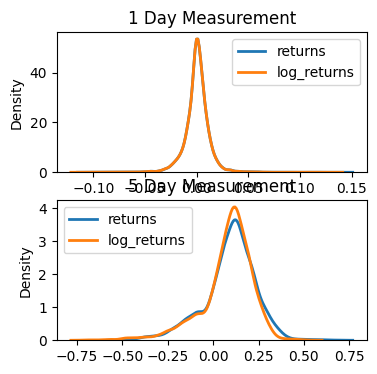

In [55]:
def calc_return(price, periods):
    return price[periods:] / price[:-periods] - 1

def calc_log_return(price, periods):
    return np.log(price[periods:] / price[:-periods])

def plot_hist_kde(data, ax):
    sns.kdeplot(data, linewidth=2, ax=ax)
    return ax
    

fig, axes = plt.subplots(2, figsize=(4,4))

returns_1 = calc_return(data["Adj Close"].values, 1)
log_returns_1 = calc_log_return(data["Adj Close"].values, 1)
plot_hist_kde(returns_1, axes[0])
plot_hist_kde(log_returns_1, axes[0])
axes[0].legend(["returns", "log_returns"])
axes[0].set_title("1 Day Measurement")

returns_5 = calc_return(data["Adj Close"].values, 200)
log_returns_5 = calc_log_return(data["Adj Close"].values, 200)
plot_hist_kde(returns_5, axes[1])
plot_hist_kde(log_returns_5, axes[1])
axes[1].legend(["returns", "log_returns"])
axes[1].set_title("5 Day Measurement")


(array([0.00711185, 0.0021186 , 0.01057086, ..., 0.00281041, 0.00376688,
        0.00340752]),
 array([0.00708668, 0.00211636, 0.01051538, ..., 0.00280647, 0.0037598 ,
        0.00340172]))